# Implementacion de un filtro trapezoidal


En este script de python se realizara el analisis de la adquisicion de señales realizada por el XADC a 1MHz

### Carga de librerias

In [1]:
# Importacion de librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import lfilter, firwin, freqz, resample
from scipy.fft import fft, ifft, fftfreq

- Modelo de eventos radioactivos

$y(t) = A(e^{(t-t_0)/\tau_D}-e^{(t-t_0)/\tau_R})$

Donde:

$A$ es Constante proporcional de Amplitud

$\tau_D$ es constante de tiempo de decaimiento de pulso

$\tau_R$ es constante de tiempo de subida de pulso

$t_0$ es Tiempo de ocurrencia del pulso


In [2]:
data = pd.read_csv("data/data_s2.csv")
y = np.array(data.iloc[:,0].values, dtype=float)[0:500000]


In [3]:
Fs = 1E6   # 1 MHz
T = 1/Fs
t = np.arange(0,(len(y)/Fs), 1/Fs)

print(y.shape)

(500000,)


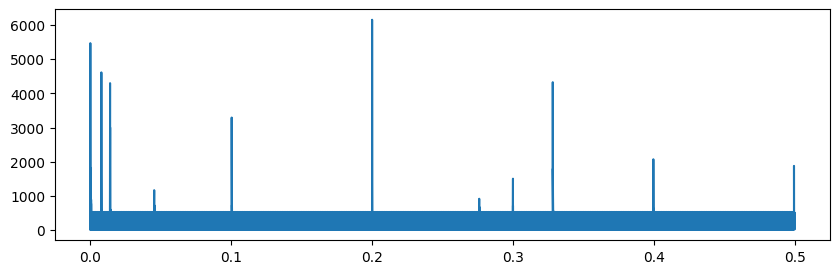

In [4]:
plt.figure(figsize=(10,3))
plt.plot(t,y)
#plt.xlim([0.127,0.128])

Obtencion de la FFT

In [5]:
Y = fft(y)
f = fftfreq(len(y), 1/Fs)

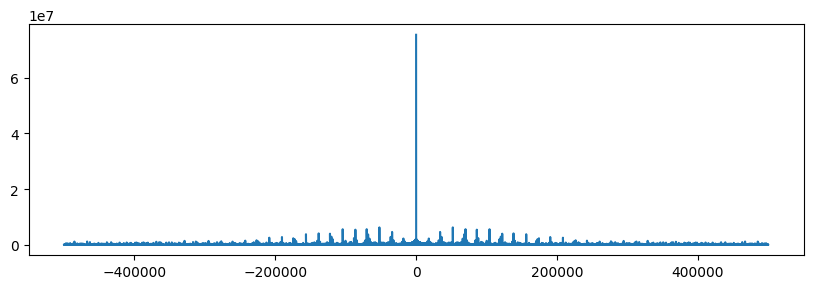

In [6]:
plt.figure(figsize=(10,3))
plt.plot(f,np.abs(Y))

<function matplotlib.pyplot.show(close=None, block=None)>

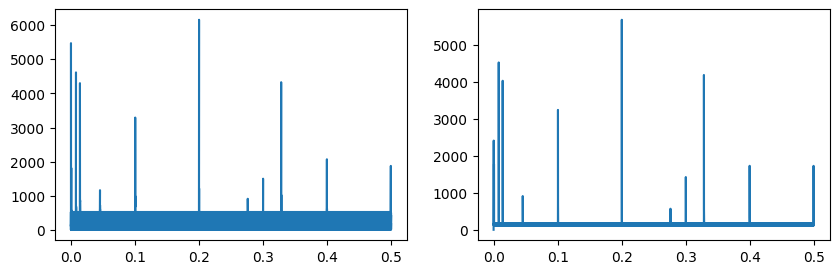

In [7]:
# Use firwin with a Kaiser window to create a lowpass FIR filter.
#taps = firwin(100, [30/(2*N), 100/(2*N)], window='hann', pass_zero='bandpass')
taps = firwin(30, [1/(2*Fs), 30000/(2*Fs)], window='hann', pass_zero='bandpass')

# Use lfilter to filter x with the FIR filter.
y_f = lfilter(taps, 1.0, y)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(t,y)
plt.subplot(1,2,2)
plt.plot(t,y_f)
#plt.xlim([0.127,0.128])
plt.show

In [8]:
coefs = np.round(taps * 2**10).astype(int)
df = pd.DataFrame(coefs)
df.to_csv('coefs.csv', index=False)

### Implementacion de trapezoidal shaper



In [21]:
# Steplike pulse
td = 2.69540167e-05 # extraido del modelo de ajuste
tr = 2.66419618e-07 # extraido del modelo de ajuste
beta = np.floor(np.exp(-T/td)*100000)
alpha = np.exp(-T/tr)

print("alpha = ", alpha)
print("beta = ", beta)

alpha =  0.023436108600347418
beta =  96357.0


In [10]:
def steplike(x):
    y = np.zeros(len(x))
    for n in range((1),len(x)):
        A = np.floor((100000*x[n] - beta*x[n-1])/100000)
        y[n] = (A + y[n-1])

    return y


def steplike_bi(x):
    y = np.zeros(len(x))
    for n in range((2),len(x)):
        A = x[n] - (alpha+beta)*x[n-1] + (alpha*beta)*x[n-2] 
        y[n] = (A + (beta-alpha)*y[n-1])/(beta-alpha)

    return y

def diff(x):
    y = np.zeros(len(x))
    for n in range((1),len(x)):
        y[n] = x[n] - x[n-1]

    return y


In [19]:
R= 5
M_ = 10

K = 5
L = 10
M = 2100



def traps(x):
    y = np.zeros(len(x))
    for n in range((R+R+M_),len(x)):
        A = x[n] - x[n-R] - x[n-R-M_] + x[n-R-M_-R]
        y[n] = (A - y[n-1])/R 

    return y

def trapz(x):
    y = np.zeros(len(x))
    b = np.zeros(len(x))
    for n in range((K+L),len(x)):
        A = x[n] - x[n-K] - x[n-L] + x[n-K-L]
        b[n] = b[n-1] + A
        C = b[n] + A*M
        
        y[n] = y[n-1] + C

    return y


<function matplotlib.pyplot.show(close=None, block=None)>

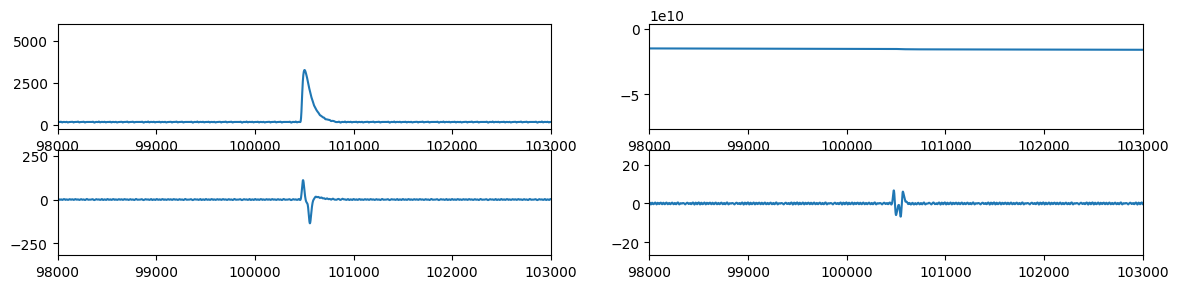

In [22]:
R= 20
M_ = 50

K = 5
L = 10
M = 2100

X_step = steplike(y_f)
X = traps(y_f)
Xd = diff(X)

plt.figure(figsize=(14,3))
plt.subplot(2,2,1)
plt.plot(t*Fs,y_f)
plt.xlim([0.098*Fs,0.103*Fs])
plt.subplot(2,2,2)
plt.plot(t*Fs,X_step)
plt.xlim([0.098*Fs,0.103*Fs])
plt.subplot(2,2,3)
plt.plot(t*Fs,X)
plt.xlim([0.098*Fs,0.103*Fs])
plt.subplot(2,2,4)
plt.plot(t*Fs,Xd)
plt.xlim([0.098*Fs,0.103*Fs])
plt.show


## TRAPS filter

![](images/img_01.png)

!["images/img_00.png"](images/img_00.png)

## TRAPZ filter

!["images/img_00.png"](images/img_04.png)

!["images/img_00.png"](images/img_03.png)

!["images/img_00.png"](images/img_05.png)